In [9]:
import os
import sys ; sys.path.append("../..")
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm.auto import tqdm
from torchvision import models, transforms
from mpl_toolkits.axes_grid1 import ImageGrid

from data.util.cocofake import get_cocofake

In [45]:
COCO_PATH = "/u00/data/coco-2014"
COCOFAKE_PATH = "/u00/data/cocofake"
MODEL_PATH = "artifacts/best_mobilenetv2.pt"

In [48]:
DEVICE = "cuda:0"
model = torch.load(MODEL_PATH).to(DEVICE)

/tmp/ipykernel_164798/137089288.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH).to(DEVICE)


In [53]:
real_transform = lambda x: transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)(transforms.CenterCrop(512)(x))

train_data, val_data, test_data, = get_cocofake(
    COCO_PATH,
    COCOFAKE_PATH,
    train_limit=10000,
    val_limit=2500,
    real_transform=real_transform,
    batch_size=4,
    train_n_workers=8,
    val_n_workers=2,
    num_fake=1
)

In [62]:
def normalize_image(img):
    return torch.clamp((img - torch.min(img)) / torch.max(img), min=0, max=1)

def plot_images(batch, model=None, **kwargs):
    batch_size = batch["real"].shape[0]
    n = min(batch_size, 4)
    fig, axes = plt.subplots(
        len(batch["fake"]) + 1, n, figsize=kwargs.pop("figsize", (12, 8))
    )
    
    real_imgs = batch["real"][:n]
    if model is not None:
        outputs = model(real_imgs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
    for i, img in enumerate(real_imgs):
        if model is not None:
            title = f"real\npred: {'real' if preds[i] == 0 else 'fake'}"
        else:
            title = "real"
        axes[0][i].imshow(normalize_image(img.permute([1, 2, 0])))
        axes[0][i].set_title(title)
    
    for i, fake_imgs in enumerate(batch["fake"], 1):
        fake_imgs = fake_imgs[:n]
        if model is not None:
            outputs = model(fake_imgs.to(DEVICE))
            _, preds = torch.max(outputs, 1)
        for j, img in enumerate(fake_imgs):
            if model is not None:
                title = f"fake\npred: {'real' if preds[i] == 0 else 'fake'}"
            else:
                title = "fake"
            axes[i][j].imshow(normalize_image(img.permute([1, 2, 0])))
            axes[i][j].set_title(title)

In [60]:
it = iter(test_data)

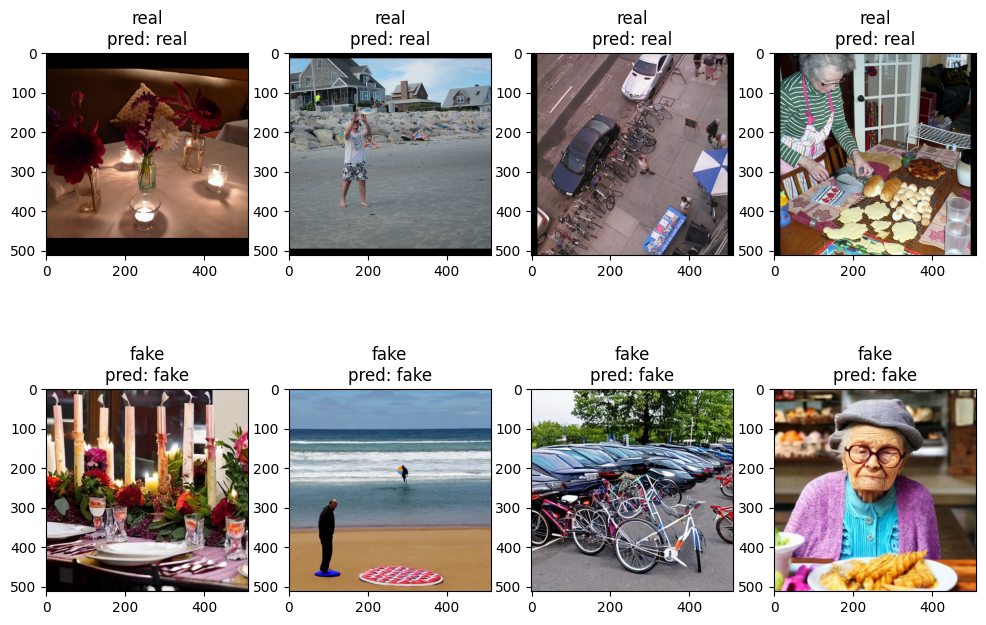

In [64]:
plot_images(next(it), model=model)